## 데이터 읽어오기

In [1]:
import glob
import os, re
import tensorflow as tf
import matplotlib.pyplot as plt

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

# txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당
txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        # read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. 
        # splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw = f.read().splitlines()
        # extend() : 리스트함수로 추가적인 내용을 연장 한다.
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]']


In [2]:
for i in range(20):
    print(i, ': ', raw_corpus[i])

0 :  
1 :  
2 :  [Spoken Intro:]
3 :  You ever want something 
4 :  that you know you shouldn't have 
5 :  The more you know you shouldn't have it, 
6 :  The more you want it 
7 :  And then one day you get it, 
8 :  It's so good too 
9 :  But it's just like my girl 
10 :  When she's around me 
11 :  I just feel so good, so good 
12 :  But right now I just feel cold, so cold 
13 :  Right down to my bones 
14 :  'Cause ooh... 
15 :  Ain't no sunshine when she's gone 
16 :  It's not warm when she's away 
17 :  Ain't no sunshine when she's gone 
18 :  And she's always gone too long 
19 :  Anytime she goes away 


In [3]:
# enumerate() 함수를 이용하여 raw_corpus list 내에 저장된 문장과
# 그 문장읜 인덱스를 반환 (인덱스, 문장 순)
for idx, sentence in enumerate(raw_corpus):
    # 길리가 0인 문장은 건너뜁니다.
    if len(sentence) == 0: continue
    # 문장의 끝이 ] 인 문장은 건너뜁니다.
    if sentence[-1] == "]": continue
    # 문장 20개만 확인.
    if idx > 19: break
        
    print(sentence)

You ever want something 
that you know you shouldn't have 
The more you know you shouldn't have it, 
The more you want it 
And then one day you get it, 
It's so good too 
But it's just like my girl 
When she's around me 
I just feel so good, so good 
But right now I just feel cold, so cold 
Right down to my bones 
'Cause ooh... 
Ain't no sunshine when she's gone 
It's not warm when she's away 
Ain't no sunshine when she's gone 
And she's always gone too long 
Anytime she goes away 


## 데이터 정제

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+'," ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [5]:
# 필터링 잘 적용됬는지 확인.
print(preprocess_sentence("This @_is ;;;sample          sentence."))

<start> this is sample sentence . <end>


In [6]:
# 필터링된 문장 저장.
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다.
    if len(sentence) == 0: continue
    if sentence[-1] == "]": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제 하고 저장합니다.
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

In [7]:
corpus[:10]

['<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>',
 '<start> but right now i just feel cold , so cold <end>']

## 평가 데이터셋 분리

In [8]:
def tokenize(corpus):
    # 15,000 단어를 기억할 수 있는 tokenizer를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=15000, filters=' ', oov_token="<unk>")
    
    # corpus를 이용해 tokenizer 내부의 단어장을 완성.
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다.
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다.
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=20)
    
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   7 156 ...   0   0   0]
 [  2  17   7 ...   0   0   0]
 [  2   6  98 ...   0   0   0]
 ...
 [  2 310   1 ...   0   0   0]
 [  2 729   5 ...   0   0   0]
 [  2 729   5 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fb347a256d0>


In [9]:
# 생성된 텐서 데이터 확인.
print(tensor[:3, :10])

[[   2    7  156   62  199    3    0    0    0    0]
 [   2   17    7   34    7 1536   15   76    3    0]
 [   2    6   98    7   34    7 1536   15   76   11]]


In [10]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형태로 반환
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    
    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [11]:
# tensor에서 마지막 토큰을 잘라서 소스 문장을 생성, 해당 토큰은 <end>가 아니라 <pad>일 가능성 높음.
src_input = tensor[:, :-1]
# tenor에서 <start>를 잘라내서 타겟 문장을 생성.
tgt_input = tensor[:, 1:]

print(src_input[0])
print(tgt_input[0])

[  2   7 156  62 199   3   0   0   0   0   0   0   0   0   0   0   0   0
   0]
[  7 156  62 199   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


훈련 데이터와 평가데이터로 분리하기!

In [12]:
from sklearn.model_selection import train_test_split
# 소스문장을 train으로 타겟 문장을 val로.
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, random_state=2023, test_size= 0.2)

In [13]:
print(enc_train.shape, enc_val.shape, dec_train.shape, dec_val.shape)

(139790, 19) (34948, 19) (139790, 19) (34948, 19)


In [14]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 15000개와, 여기 포함되지 않은 0:<pad>를 포함하여 15001개
# tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
# tokenize() 함수에서 num_words를 15000개로 선언했기 때문에, tokenizer.num_words의 값은 15000개
VOCAB_SIZE = tokenizer.num_words + 1

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder = True)
train_dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

In [16]:
test_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

## 모델 만들기

In [17]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다.
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [18]:
# embedding size 값이 커질 수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만,
# 데이터의 양이 적으면 긍정적인 결과가 나오지 않을 수 있다.
# 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
embedding_size = 512
hidden_size = 2048
lyricist = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)

In [19]:
# 데이터셋에서 데이터 한 배치만 가져와서 모델에 넣어서 확인.
for src_sample, tgt_sample in train_dataset.take(1): break

lyricist(src_sample)

<tf.Tensor: shape=(256, 19, 15001), dtype=float32, numpy=
array([[[-2.12005645e-04, -9.40071277e-06,  3.00720803e-05, ...,
         -3.98123375e-04, -1.31781766e-04,  2.82347974e-05],
        [-6.64547435e-04,  2.03372092e-05, -1.12552989e-04, ...,
         -4.61010321e-04, -2.46895826e-04, -1.16550182e-04],
        [-6.56825840e-04,  1.63737044e-04, -5.14869404e-04, ...,
         -6.05526089e-04, -3.32437688e-04,  2.66351308e-05],
        ...,
        [-1.95101020e-03, -1.10491144e-03, -2.54284241e-04, ...,
          2.38108201e-04,  1.69556748e-04,  3.42361885e-03],
        [-2.24965904e-03, -7.70948594e-04, -5.82447392e-04, ...,
          1.22626472e-04,  8.09380290e-05,  3.74271208e-03],
        [-2.47167004e-03, -4.88065241e-04, -9.30586306e-04, ...,
          9.29717407e-06, -4.39854412e-05,  4.03105235e-03]],

       [[-2.12005645e-04, -9.40071277e-06,  3.00720803e-05, ...,
         -3.98123375e-04, -1.31781766e-04,  2.82347974e-05],
        [-5.04918396e-04,  1.26791419e-04, -2

In [20]:
# 모델 구조 확인.
lyricist.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  7680512   
_________________________________________________________________
lstm (LSTM)                  multiple                  20979712  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  30737049  
Total params: 92,959,897
Trainable params: 92,959,897
Non-trainable params: 0
_________________________________________________________________


In [21]:
# optimizer로는 사용빈도가 높은 Adam으로 선택.
optimizer = tf.keras.optimizers.Adam()

# 훈련 데이터의 라벨이 정수의 형태로 제공될 때, 사용하는 손실함수.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
# from_logits 의 기본값은 False. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려줌.
# 즉, softmax 함수가 적용되지 않았다는걸 의미.
# reduction 의 기본값은 SUM. 각자 나오는 값의 반환을 원할 때, None을 사용.

lyricist.compile(loss=loss, optimizer=optimizer)
history = lyricist.fit(train_dataset, validation_data=test_dataset, epochs=10)

Epoch 1/10
546/546 [==============================] - 393s 712ms/step - loss: 2.8394 - val_loss: 2.5089
Epoch 2/10
546/546 [==============================] - 393s 720ms/step - loss: 2.3836 - val_loss: 2.3169
Epoch 3/10
546/546 [==============================] - 395s 722ms/step - loss: 2.1911 - val_loss: 2.1927
Epoch 4/10
546/546 [==============================] - 395s 723ms/step - loss: 2.0224 - val_loss: 2.1008
Epoch 5/10
546/546 [==============================] - 395s 723ms/step - loss: 1.8642 - val_loss: 2.0272
Epoch 6/10
546/546 [==============================] - 395s 724ms/step - loss: 1.7158 - val_loss: 1.9692
Epoch 7/10
546/546 [==============================] - 394s 722ms/step - loss: 1.5750 - val_loss: 1.9253
Epoch 8/10
546/546 [==============================] - 395s 722ms/step - loss: 1.4408 - val_loss: 1.8857
Epoch 9/10
546/546 [==============================] - 395s 723ms/step - loss: 1.3130 - val_loss: 1.8563
Epoch 10/10
546/546 [==============================] - 395s 723m

In [17]:
# 문장생성 함수 정의
# 모델에게 시작 문장을 전달하면 시작 문장을 바탕으로 작문을 진행.
# 시작 문자열을 init_sentence 로 받으며, 디폴트 값은 <start> 를 받음.
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해, 입력 받은 init_sentence로 텐서로 변환.
    # 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    # 단어 하나씩 예측해 문장을 생성
    # 1. 입력받은 문장의 텐서를 입력.
    # 2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냄.
    # 3. 2에서 예측된 word index를 문장 뒤에 붙임.
    # 4. 모델이 <end>를 예측햇거나, max_len에 도달했다면 문장 생성을 마침.
    # 루프를 돌면서 init_sentence에 단어를 하나씩 생성
    while True:
        # 1
        predict = model(test_tensor)
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        # 3
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break
    
    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다.
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
    
    # 모델이 생성한 문장을 반환.
    return generated

In [23]:
generate_text(lyricist, tokenizer, init_sentence="<start> i think", max_len=20)

'<start> i think i m gonna love you now <end> '

In [24]:
generate_text(lyricist, tokenizer, init_sentence="<start> i want", max_len=20)

'<start> i want to diggin the scene with a gangsta lean <end> '

In [25]:
generate_text(lyricist, tokenizer, init_sentence="<start> you should", max_len=20)

'<start> you should already know <end> '

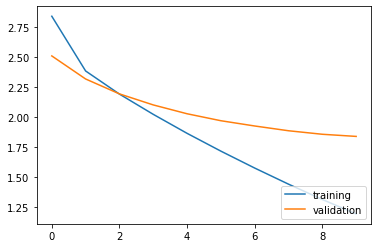

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

## dropout 추가

In [27]:
class TextGenerator_1(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size = 512
hidden_size = 2048
lyricist_1 = TextGenerator_1(tokenizer.num_words + 1, embedding_size, hidden_size)

In [28]:
optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

lyricist_1.compile(loss=loss, optimizer=optimizer)
history_1 = lyricist_1.fit(train_dataset, validation_data=test_dataset, epochs=10)

Epoch 1/10
546/546 [==============================] - 562s 993ms/step - loss: 2.8701 - val_loss: 2.5269
Epoch 2/10
546/546 [==============================] - 544s 996ms/step - loss: 2.4006 - val_loss: 2.3192
Epoch 3/10
546/546 [==============================] - 544s 997ms/step - loss: 2.2014 - val_loss: 2.1882
Epoch 4/10
546/546 [==============================] - 545s 997ms/step - loss: 2.0404 - val_loss: 2.1012
Epoch 5/10
546/546 [==============================] - 545s 997ms/step - loss: 1.9036 - val_loss: 2.0371
Epoch 6/10
546/546 [==============================] - 545s 998ms/step - loss: 1.7896 - val_loss: 1.9919
Epoch 7/10
546/546 [==============================] - 545s 998ms/step - loss: 1.6951 - val_loss: 1.9591
Epoch 8/10
546/546 [==============================] - 545s 998ms/step - loss: 1.6153 - val_loss: 1.9356
Epoch 9/10
546/546 [==============================] - 544s 997ms/step - loss: 1.5490 - val_loss: 1.9180
Epoch 10/10
546/546 [==============================] - 545s 998m

In [29]:
lyricist_1.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  7680512   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  20979712  
_________________________________________________________________
lstm_3 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense_1 (Dense)              multiple                  30737049  
Total params: 92,959,897
Trainable params: 92,959,897
Non-trainable params: 0
_________________________________________________________________


In [30]:
generate_text(lyricist_1, tokenizer, init_sentence="<start> i think", max_len=20)

'<start> i think i m crazy <end> '

In [31]:
generate_text(lyricist_1, tokenizer, init_sentence="<start> i want", max_len=20)

'<start> i want to diggin the scene with a gangsta lean <end> '

In [32]:
generate_text(lyricist_1, tokenizer, init_sentence="<start> you should", max_len=20)

'<start> you should be stronger than me <end> '

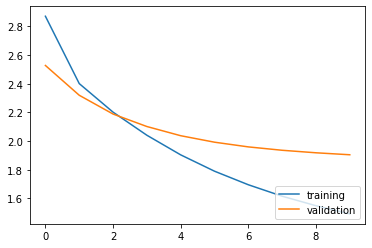

In [33]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

## 번외. Bidirectional 시도

In [18]:
class TextGenerator_2(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        # dropout을 낮추고 recurrent를 없애도됨, 에폭이랑 임베딩, 히든 사이즈를 다시 늘리기를 권장, 
        # 바이디렉셔녈이라 2번 훑어서 dropout도 2번이라는 추정.거기에 recurrent라 더 많을것이라는 추정.
        self.rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
        #self.rnn_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
        self.linear = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        #out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size = 128
hidden_size = 256
lyricist_2 = TextGenerator_2(tokenizer.num_words + 1, embedding_size, hidden_size)

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

lyricist_2.compile(loss=loss, optimizer=optimizer)
history_2 = lyricist_2.fit(train_dataset, validation_data=test_dataset, epochs=5)

Epoch 1/5
546/546 [==============================] - 56s 95ms/step - loss: 2.8662 - val_loss: 1.9951
Epoch 2/5
546/546 [==============================] - 53s 97ms/step - loss: 1.5176 - val_loss: 1.1416
Epoch 3/5
546/546 [==============================] - 53s 96ms/step - loss: 0.8841 - val_loss: 0.7030
Epoch 4/5
546/546 [==============================] - 53s 96ms/step - loss: 0.5323 - val_loss: 0.4557
Epoch 5/5
546/546 [==============================] - 53s 96ms/step - loss: 0.3254 - val_loss: 0.3171


In [20]:
lyricist_2.summary()

Model: "text_generator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1920128   
_________________________________________________________________
bidirectional (Bidirectional multiple                  788480    
_________________________________________________________________
dense (Dense)                multiple                  7695513   
Total params: 10,404,121
Trainable params: 10,404,121
Non-trainable params: 0
_________________________________________________________________


In [21]:
generate_text(lyricist_2, tokenizer, init_sentence="<start> i think", max_len=20)

'<start> i think pusha wantcha romey romey romey romey romey rome romey romey romey romey romey awards awards <end> '

In [26]:
generate_text(lyricist_2, tokenizer, init_sentence="<start> we ever", max_len=20)

'<start> we ever dreamed transcend afar thugga lemon mayne popping <end> '

In [31]:
generate_text(lyricist_2, tokenizer, init_sentence="<start> you know ", max_len=20)

'<start> you know <end> '

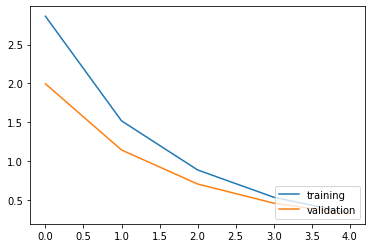

In [24]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

## 회고

* 처음에는 12000단어, embedding_size = 256, hidden_size = 1024 로 학습시키고 문장을 뽑으면, 조금 어색한 단어들의 나열이었다면,  
    15000단어, embedding_size = 512, hidden_size = 2048 늘리고 테스트 해보니 조금은 양호 해진듯한 느낌이 듭니다.  
* dropout을 사용해서 loss가 val_loss와의 간격이 조금 줄어들었지만, 문장생성에 큰 영향은 없는것 같습니다.

* 호기심에 Bidirectional 을 사용해 봤지만, batch_size=[32,64,128,256], keras.layers.Embedding의 output_dim=[32,64,128,256,512], keras.layers.LSTM의 units=[64,128, 256, 512, 1024, 2048], epochs=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dropout=[0.1, 0.2, 0.3, 0.4, 0.5] Bidirectional의 layer를 2개 사용하기 등 다양한 수치들로 실험해 봤지만 제대로된 문장을 구성한적이 없었습니다. bidirectional의 layer를 2층으로 할때와 일부 수치들을 낮춰서 해보다가 들었던 생각이지만, 위 코드들로 무언가 과하게 학습이되서 제대로된 문장이 출력되지 않는다는 생각이 들었습니다. 그후 bidirectional 층을 하나로만 두고 다른 수치들은 건드려보면 무언가 문장은 나오지만 같은 단어가 반복되는 문제가 생기는 것을 보고, 해당 단어들이 갖는 추상적 의미의 범위가 너무 큰것은 아닌지 생각하고 수치들을 더 낮췄지만, 개선되지 않았습니다. 여기서 더 낮춰서 일부 문장을 유도하기위해 선행문장을 조정하면 데이터에 존재하는 문장이 그대로 출력되는 경우가 생기기도 했습니다. 기본적으로 모델생성 부분에서 문제가 있겠지만, 추가적으로 생각해본것은 데이터셋을 더 많이 사용한다던지, tokenize 부분을 고쳐본다던지, 혹은 그외의 설계부분에서 bidirectional에는 맞지않는 부분이 있을 수 있다는 생각은 해보았지만 좀 더 해당분야의 지식을 늘리고 시도해봐야 할것 같습니다.

해당 프로젝트를 진행하면서 NLP는 이전에 시도했던 cv파트보다 학습속도가 많이 소요되어서 기다리는 시간이 더 길었지만, 파라미터들을 조금씩 바꿀때마다 출력되는 문장을 구성하는 단어들이 바뀌는것을 보고 단어 출현 조건에 대해 여러 생각들을 할 수 있었던 시간이었습니다.
또한 bidirectional을 시도해보면서 NLP에서의 loss와 val_loss는 해당 수치가 낮다고 더 좋은 모델이라고 판단할 수 있는 지표라고 보기에는 조금 어려울 수 있다고 생각했습니다. 제가 시도해볼때는 낮은 loss임에도 매번 좋은 문장이 구성되는것을  볼 수 없었기 때문입니다...